# Deep Learning with PyTorch : Build a Generative Adversarial Network

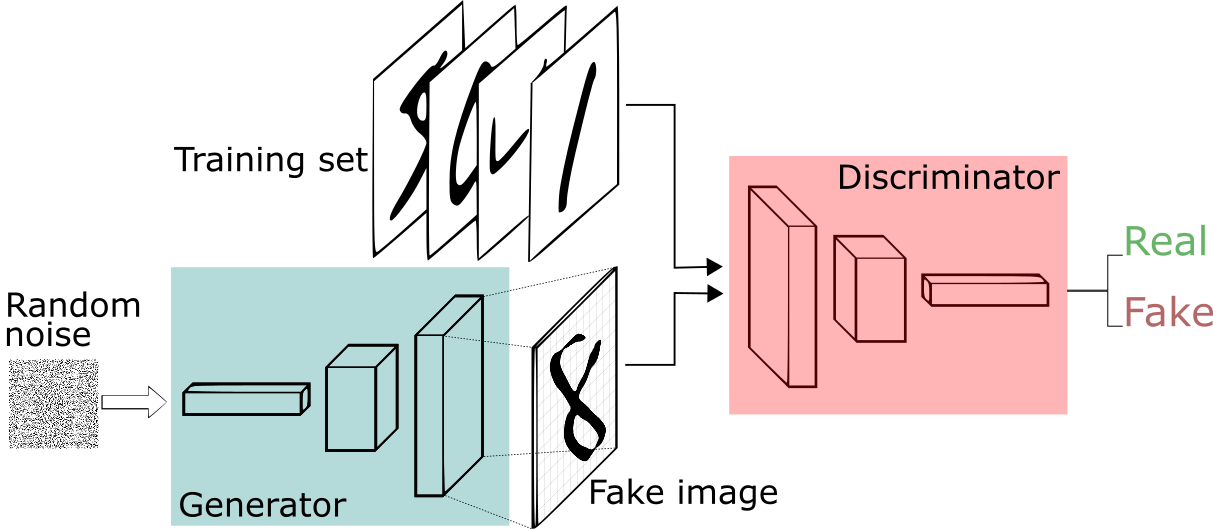

In [1]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Task 1: Configurations

In [2]:
DEVICE = 'cuda'
BATCH_SIZE = 128
NOISE_DIM = 64

# Optimizers
LR = 0.0002
BETA1 = 0.5 # Adam
BETA2 = 0.99

# Training
EPOCHS = 30

# Task 2: Load MNIST Dataset

In [3]:
from torchvision import datasets, transforms as T

In [4]:
train_augs = T.Compose([
    T.RandomRotation((-20, +20)),
    T.ToTensor()  # (h, w, c) => (c, h, w)
])

In [5]:
trainset = datasets.MNIST('MNIST/', download=True, train=True, transform=train_augs)

100%|█████████████████████████████████████████████| 9912422/9912422 [00:01<00:00, 5631672.72it/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 17821935.24it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



100%|█████████████████████████████████████████████| 1648877/1648877 [00:01<00:00, 1598554.39it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|███████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 7066219.87it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



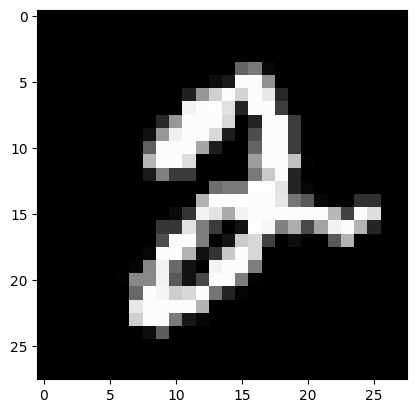

In [6]:
image, label = trainset[5]
plt.imshow(image.squeeze(), cmap='gray')

In [7]:
print(f'totol images in trainset: {len(trainset)}')

totol images in trainset: 60000


# Task 3: Load Dataset Into Batches

In [8]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [9]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
print(f'total num of batches in trainloader: {len(trainloader)}')

total num of batches in trainloader: 469


In [11]:
_, (image, _) = next(enumerate(trainloader))
print(image.shape)

torch.Size([128, 1, 28, 28])


In [12]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

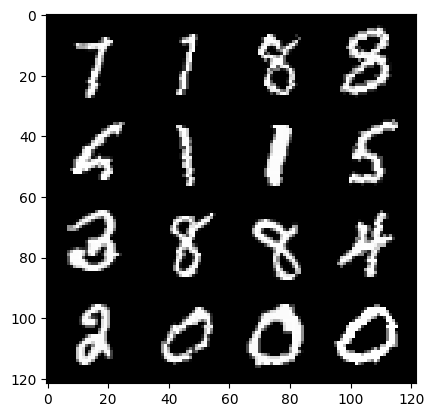

In [13]:
show_tensor_images(image, num_images=16)

# Task 4: Create Discriminator Network

In [14]:
#In case if torch summary is not installed

!pip install torchsummary

Looking in indexes: https://mirrors.aliyun.com/pypi/simple


In [15]:
from torch import nn
from torchsummary import summary

'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

In [17]:
def get_discrim_block(in_channels: int, out_channels: int, kernel_size:
                      tuple, stride: int):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

In [18]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.block_1 = get_discrim_block(1, 16, (3,3), 2)
        self.block_2 = get_discrim_block(16, 32, (5,5), 2)
        self.block_3 = get_discrim_block(32, 64, (5,5), 2)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=64, out_features=1)

    def forward(self, images):
        x1 = self.block_1(images)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)

        x4 = self.flatten(x3)
        x5 = self.linear(x4)

        return x5

In [19]:
D = Discriminator()
D.to(DEVICE)
summary(D, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Task 5: Create Generator Network

In [21]:
def get_gen_block(in_channels: int, out_channels: int, kernel_size: tuple,
                  stride: int, final_block: bool = False):
    if final_block:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.Tanh()
        )
    else:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

In [22]:
class Generator(nn.Module):

    def __init__(self, noise_dim):
        super(Generator, self).__init__()

        self.noise_dim = noise_dim
        self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
        self.block_2 = get_gen_block(256, 128, (4,4), 1)
        self.block_3 = get_gen_block(128, 64, (3,3), 2)
        self.block_4 = get_gen_block(64, 1, (4,4), 2, final_block=True)

    def forward(self, r_noise_vec):
        # (bat_size, noise_vec) => (bat_size, noise_vec, 1, 1)
        x = r_noise_vec.view(-1, self.noise_dim, 1, 1)
        x1 = self.block_1(x)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)
        x4 = self.block_4(x3)
        return x4

In [23]:
G = Generator(noise_dim=NOISE_DIM)
G.to(DEVICE)
summary(G, input_size=(1, NOISE_DIM))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [24]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [25]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Task 6: Create Loss Function and Load Optimizer

In [26]:
def real_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.ones_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss

def fake_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.zeros_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss

In [27]:
D_opt = torch.optim.Adam(D.parameters(), lr=LR, betas=(BETA1, BETA2))
G_opt = torch.optim.Adam(G.parameters(), lr=LR, betas=(BETA1, BETA2))

# Task 7: Training Loop

In [29]:
losses = []

for epoch in range(EPOCHS):
    total_d_loss = 0.0
    total_g_loss = 0.0

    for real_img, _ in trainloader:
        real_img = real_img.to(DEVICE)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, device=DEVICE)

        # find loss and update weights for D
        D_opt.zero_grad()

        fake_img = G(noise)
        D_pred = D(fake_img)
        D_fake_loss = fake_loss(D_pred)

        D_pred = D(real_img)
        D_real_loss = real_loss(D_pred)

        D_loss = (D_real_loss + D_fake_loss) / 2
        total_d_loss += D_loss.item()

        D_loss.backward()

        D_opt.step()

        # find loss and update weights for G
        G_opt.zero_grad()

        noise = torch.randn(BATCH_SIZE, NOISE_DIM, device=DEVICE)

        fake_img = G(noise)
        D_pred = D(fake_img)
        G_loss = real_loss(D_pred)
        total_g_loss += G_loss.item()

        G_loss.backward()
        G_opt.step()

    avg_d_loss = total_d_loss/len(trainloader)
    avg_g_loss = total_g_loss/len(trainloader)

    print(f'epoch {epoch+1} | D loss: {avg_d_loss} | G loss: {avg_g_loss}')
    losses.append({'epoch': epoch, 'd_loss': avg_d_loss, 'g_loss': avg_g_loss})

epoch 1 | D loss: 0.588648942869101 | G loss: 0.8720501127527721
epoch 2 | D loss: 0.5988454914042182 | G loss: 0.8698141327036469
epoch 3 | D loss: 0.6065061671901614 | G loss: 0.8644288635965603
epoch 4 | D loss: 0.6133810762149184 | G loss: 0.857391022288723
epoch 5 | D loss: 0.6203701006832407 | G loss: 0.850558826791198
epoch 6 | D loss: 0.6272033391985049 | G loss: 0.8403412906854137
epoch 7 | D loss: 0.6294127884449989 | G loss: 0.8410326668194362
epoch 8 | D loss: 0.6331408424163932 | G loss: 0.8314644042362791
epoch 9 | D loss: 0.6356169121351831 | G loss: 0.8280237107388755
epoch 10 | D loss: 0.6375699279659084 | G loss: 0.8277842139384386
epoch 11 | D loss: 0.6382324166897771 | G loss: 0.8259404294018043
epoch 12 | D loss: 0.6383174540899964 | G loss: 0.8254509278451965
epoch 13 | D loss: 0.6388015334031729 | G loss: 0.827757845682376
epoch 14 | D loss: 0.6397018374156341 | G loss: 0.8257396908711269
epoch 15 | D loss: 0.6397239123580298 | G loss: 0.8260977167818846
epoch 16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


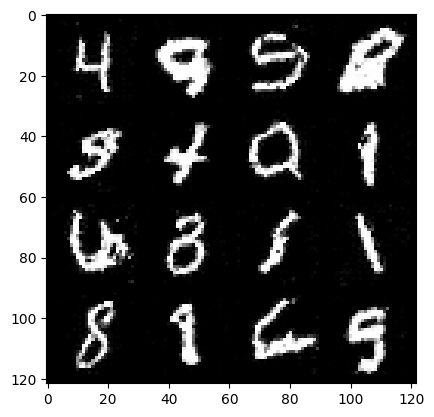

In [30]:
show_tensor_images(fake_img)

<Axes: xlabel='epoch'>

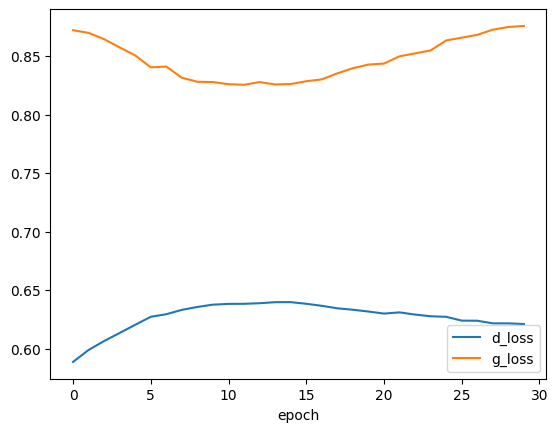

In [31]:
import pandas as pd
pd.DataFrame(losses).set_index('epoch').plot(kind='line')

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya